**Task: Brass Metal Identification using Deep Learning**

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Image_size=256
Batch_size=32
Channels=3

**Gathering data**

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brass dataset",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
 )

Found 323 files belonging to 2 classes.


In [6]:
# classes
class_names=dataset.class_names
class_names

['Brass Metal', 'Non Brass Metal']

In [7]:
for Image_batch,label_batch in dataset.take(1):
  print(Image_batch[0].shape)

(256, 256, 3)


In [8]:
train_size=0.8
len(dataset)*train_size

8.8

In [9]:
train_ds=dataset.take(12)
len(train_ds)

11

In [10]:
test_ds=dataset.skip(2)
len(test_ds)

9

**Split Dataset**

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size=int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)  
    return train_ds,val_ds, test_ds


In [13]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

8

In [15]:
len(val_ds)

1

In [16]:
len(test_ds)

2

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Data augmentation**

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomCrop(height=256, width=256),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomFlip("vertical"),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),

])

**Rescale Data**

In [19]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Create CNN Model**

In [20]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = len(dataset.class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.008)),
    layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),  # Binary classification output layer
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 batch_normalization (Batch  (32, 254, 254, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)       

**Compile and Train Model**

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy', 'Precision', 'Recall'])

epochs = 39
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/39
8/8 [==============================] - 17s 341ms/step - loss: 6.4459 - accuracy: 0.7461 - precision: 0.7791 - recall: 0.8141 - val_loss: 62.7582 - val_accuracy: 0.2188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/39
8/8 [==============================] - 1s 107ms/step - loss: 5.0313 - accuracy: 0.8086 - precision: 0.8905 - recall: 0.7821 - val_loss: 16.4569 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 1.0000
Epoch 3/39
8/8 [==============================] - 1s 108ms/step - loss: 3.9015 - accuracy: 0.8789 - precision: 0.8931 - recall: 0.9103 - val_loss: 7.0878 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 1.0000
Epoch 4/39
8/8 [==============================] - 1s 114ms/step - loss: 3.6139 - accuracy: 0.8789 - precision: 0.8882 - recall: 0.9167 - val_loss: 4.0820 - val_accuracy: 0.7500 - val_precision: 0.7931 - val_recall: 0.9200
Epoch 5/39
8/8 [==============================] - 1s 101ms/step - loss: 3.2176 - accuracy: 0.9141 - p

**I got 97.27% accuracy**

In [23]:
# Validation accuracy
accuracy = model.evaluate(val_ds)

1/1 [==============================] - 0s 51ms/step - loss: 0.4871 - accuracy: 0.9375 - precision: 0.9600 - recall: 0.9600


In [24]:
# Testing accuracy
scores=model.evaluate(test_ds)

2/2 [==============================] - 1s 43ms/step - loss: 0.6040 - accuracy: 0.9062 - precision: 0.9167 - recall: 0.9167


**Chack One Test Image**

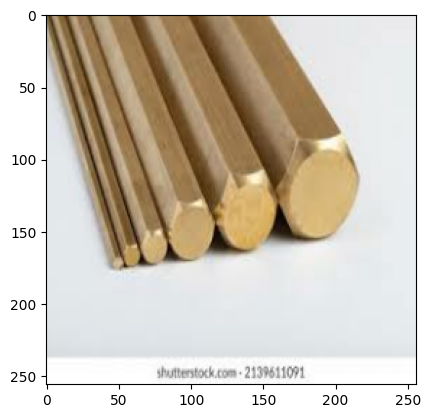

In [32]:
 for images_batch,lable_batch in test_ds.take(3):
  plt.imshow(images_batch[3].numpy().astype('uint8'))

**Model predictions**

first image to predict
first image's actual lable: Brass Metal
1/1 [==============================] - 0s 41ms/step
predicted lable: Brass Metal


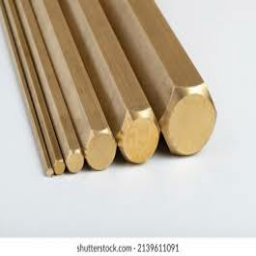

In [30]:
# output show input image and predicated output 
for image_batch, labels_batch in test_ds.take(1):
    first_image= images_batch[3].numpy().astype('uint8')
    first_lable=labels_batch[3].numpy()
    print("first image to predict")
    print("first image's actual lable:",class_names[first_lable])
    batch_prediction=model.predict(images_batch)
    print("predicted lable:",class_names[np.argmax(batch_prediction[0])])
    original_image = np.array(first_image)
    cv2_imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))


first image to predict
first image's actual lable: Brass Metal
1/1 [==============================] - 0s 43ms/step
predicted lable: Brass Metal


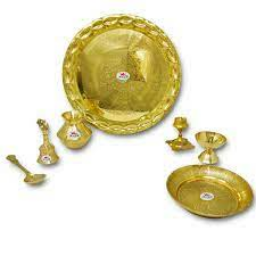

In [29]:
for image_batch, labels_batch in test_ds.take(1):
    first_image= images_batch[0].numpy().astype('uint8')
    first_lable=labels_batch[0].numpy()
    print("first image to predict")
    print("first image's actual lable:",class_names[first_lable])
    batch_prediction=model.predict(images_batch)
    print("predicted lable:",class_names[np.argmax(batch_prediction[1])])
    original_image = np.array(first_image)
    cv2_imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

In [ ]:
## Saving the Model
model.save('Best_model.tf', save_format='tf')